Followed the tutorial from this link: https://heartbeat.fritz.ai/using-a-keras-embedding-layer-to-handle-text-data-2c88dc019600

How to set up tensorflow and Keras (Mac): https://www.youtube.com/watch?v=mcIKDJYeyFY

How to set up tensorflow and Keras (Windows): https://www.youtube.com/watch?v=59duINoc8GM

Twitter GloVe embeddings: https://www.kaggle.com/jdpaletto/glove-global-vectors-for-word-representation

In [1]:
import tensorflow as tf
from numpy import array
import numpy as np
import pandas as pd
import csv
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split 

Using TensorFlow backend.


### 1) Load in our cleaned Twitter data.

In [2]:
df = pd.read_csv('/Users/graceganzel/Desktop/School/LHS712/SMM4H/task1_training_cleaned.tsv', delimiter = '\t', header = None)
df.head()

,0,1
0,0,<user> doctor christian </user> scared to star...
1,0,"<user> intuitive gal 1 </user> ok , if you sto..."
2,0,novartis announces secukinumab ( ain 457 ) dem...
3,1,""" u wailed all night ; now y'r disembodied sob..."
4,0,<user> ira paps </user> you are so fucking sel...


### 2) Split the data into train and test

In [3]:
docs = df[1]
labels = array(df[0])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size = 0.33, random_state=42)

### 3) Prepare our data

> We will need to:
> - Tokenize,
> - Encode,
> - And pad our data

#### What is encoding and padding?

> Machine learning models only accept numerical data. Therefore, we need to **encode** our data -> convert the words into series' of integers.

> In Keras, we usually want to pass arrays of integers of the same length. Thus, we **pad** our sequences -> add zeros to the beginning or end of each series of integers to make them the same length

Here is what one of our tweets look like:

In [5]:
print(X_train[1])

<user> intuitive gal 1 </user> ok , if you stopped taking the lamictal , give 90mg a week .


In [6]:
# obtain the vocabulary size to be used with one_hot encoding
t = Tokenizer()

tweets_lst = []
for tweet in X_train:
    tweets_lst.append(tweet)

t.fit_on_texts(tweets_lst)
vocab_size = len(t.word_index) + 1

In [7]:
# encoding with one_hot
X_train = [one_hot(tweet, vocab_size, filters='!"#$%&()*+,-./:;=?@[\]^_`{|}~', split=' ') for tweet in X_train]
X_test = [one_hot(tweet, vocab_size, filters='!"#$%&()*+,-./:;=?@[\]^_`{|}~', split=' ') for tweet in X_test]

This is what the tweet looks like after encoding:

In [8]:
print(X_train[1])

[14162, 21838, 17273, 525, 9951, 18556, 20931, 7217, 9244, 10190, 20931, 13210, 17931, 21648, 4753, 19608, 20931, 21224, 7211, 14959, 3924, 19469, 17279, 13154, 8744]


In [9]:
# padding
X_train = pad_sequences(X_train, maxlen=300, padding='pre')
X_test = pad_sequences(X_test, maxlen=300, padding='pre')

And this is what the tweet looks like after padding:

In [10]:
print(X_train[1])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

### 4) Load in the pre-trained GloVe embeddings

This step takes a bit of time.

In [12]:
embeddings_index = dict()
f = open('/Users/graceganzel/Desktop/School/LHS712/SMM4H/Pokee/graces_code/glove.twitter.27B.50d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

### 5) Create an embedding matrix

In [13]:
embedding_matrix = np.zeros((vocab_size, 50)) # use 50 because our vectors are of dimension 50

for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word) # get the vector from our pretrained glove embeddings
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # insert that into our matrix

### 6) Build and compile our model

>I created a model that had 3 types of layers:
> - **Embedding layer:** will take our padded sequences and turn them into vectors using the weights from our GloVe embeddings
> - **Flatten layer:** the output of our embedding layer must be flattened before being passed to the dense layer
> - **Dense layer:** a classic neural network layer

In [14]:
model = tf.keras.models.Sequential() # initialize the neural network
model.add(tf.keras.layers.Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=300 , trainable=False))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

After making our model we must compile it:

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 50)           1094150   
_________________________________________________________________
flatten (Flatten)            (None, 15000)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                150010    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,244,171
Trainable params: 150,021
Non-trainable params: 1,094,150
_________________________________________________________________
None


### 7) Fit our model to our train data and print out some results

In [17]:
model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
10888/10888 [==============================] - 2s 198us/step - loss: 0.3087 - acc: 0.9141
Epoch 2/20
10888/10888 [==============================] - 2s 147us/step - loss: 0.2632 - acc: 0.9159
Epoch 3/20
10888/10888 [==============================] - 2s 154us/step - loss: 0.2431 - acc: 0.9163
Epoch 4/20
10888/10888 [==============================] - 2s 150us/step - loss: 0.2225 - acc: 0.9199
Epoch 5/20
10888/10888 [==============================] - 2s 147us/step - loss: 0.2030 - acc: 0.9242
Epoch 6/20
10888/10888 [==============================] - 2s 150us/step - loss: 0.1815 - acc: 0.9302
Epoch 7/20
10888/10888 [==============================] - 2s 150us/step - loss: 0.1604 - acc: 0.9352
Epoch 8/20
10888/10888 [==============================] - 2s 150us/step - loss: 0.1414 - acc: 0.9398
Epoch 9/20
10888/10888 [==============================] - 2s 169us/step - loss: 0.1257 - acc: 0.9425
Epoch 10/20
10888/10888 [==============================] - 2s 153us/step - loss: 0.1104 - a

In [19]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9979
Testing Accuracy:  0.8758


In [39]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.9990
Testing Accuracy:  0.8423


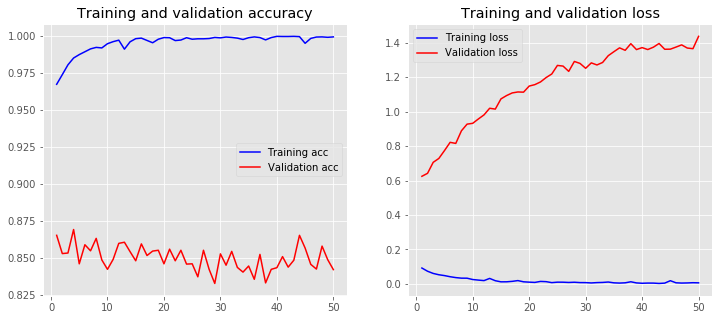

In [40]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### 8) Going to attempt LSTM

> Will need 5 types of layers
> - Embedding
> - Flatten
> - Dense
> - LSTM
> - Dropout

In [ ]:
from keras.layers import LSTM
from keras.layers import Dropout
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=300 , trainable=False))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.LSTM(units = 50))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)